# Anemia Dataset: EDA, Cleaning & Visualization

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


# Try TensorFlow for CNN
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Concatenate
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False

In [3]:
# Styling
PALETTE = {
    'primary':   '#C62828',   # deep red (blood / alert)
    'secondary': '#1565C0',   # clinical blue
    'accent':    '#F9A825',   # amber warning
    'positive':  '#2E7D32',   # green (healthy)
    'bg':        '#FAFAFA',
    'text':      '#212121',
}
sns.set_theme(style="whitegrid", font_scale=1.15)
plt.rcParams.update({
    'figure.facecolor': PALETTE['bg'],
    'axes.facecolor':   PALETTE['bg'],
    'axes.edgecolor':   '#BDBDBD',
    'text.color':       PALETTE['text'],
    'font.family':      'DejaVu Sans',
})

DATA_PATH   = '../data/raw/anemia_dataset.csv'
OUTPUT_DIR  = '../reports/figures/'
CLEANED_OUT = '../data/processed/anemia_cleaned.csv'

In [4]:
# Loading Raw Data
df_raw = pd.read_csv(DATA_PATH)
print("RAW ANEMIA DATASET")
print(f"Shape        : {df_raw.shape}")
print(f"Columns      : {list(df_raw.columns)}")
print(f"\nHead:\n{df_raw.head()}")
print(f"\nData Types:\n{df_raw.dtypes}")
print(f"\nNull Counts:\n{df_raw.isnull().sum()}")
print(f"\nDescriptive Stats:\n{df_raw.describe()}")

RAW ANEMIA DATASET
Shape        : (104, 14)
Columns      : ['Number', 'Name', '%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb', 'Anaemic', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']

Head:
   Number        Name  %Red Pixel  %Green pixel  %Blue pixel    Hb Anaemic  \
0       1  Jafor Alam     43.2555       30.8421      25.9025   6.3     Yes   
1       2     khadiza     45.6033       28.1900      26.2067  13.5      No   
2       3        Lalu     45.0107       28.9677      26.0215  11.7      No   
3       4   Mira nath     44.5398       28.9899      26.4703  13.5      No   
4       5     monoara     43.2870       30.6972      26.0158  12.4      No   

   Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  Unnamed: 12  \
0         NaN         NaN         NaN          NaN          NaN          NaN   
1         NaN         NaN         NaN          NaN          NaN          NaN   
2         NaN         NaN         NaN     

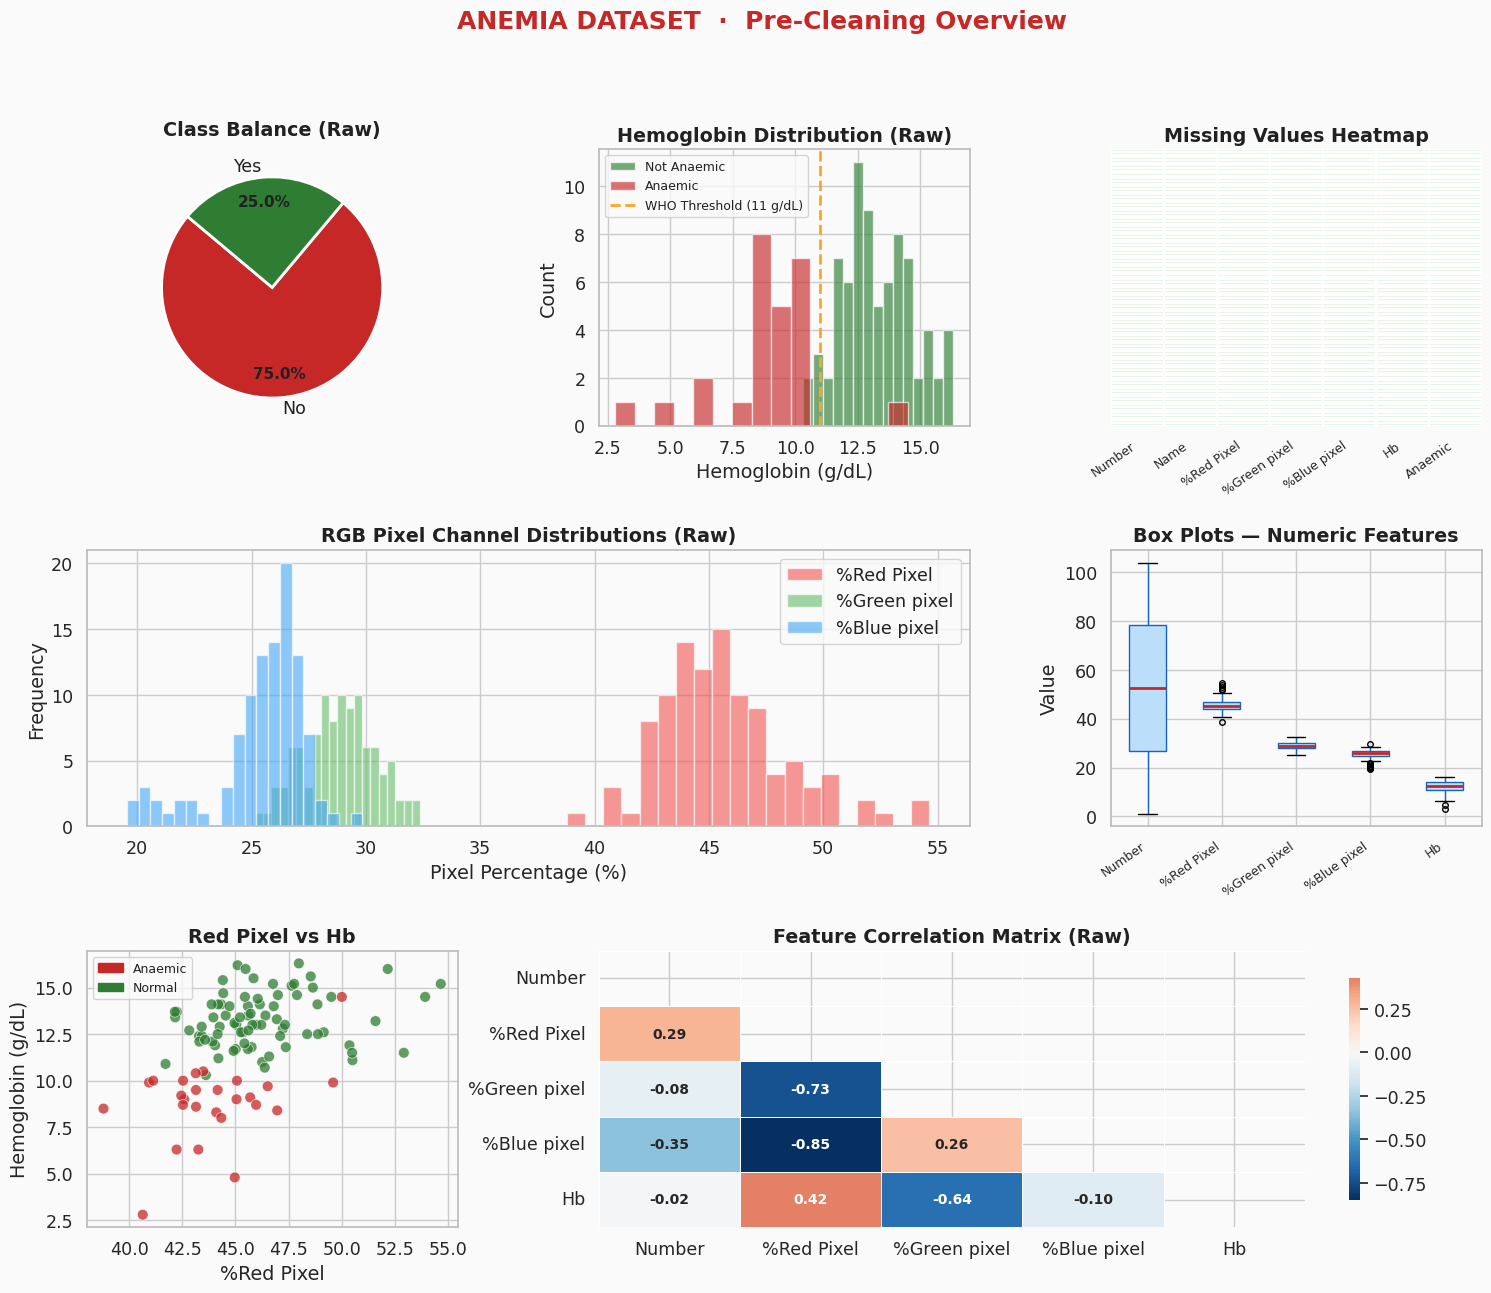


 Saved: anemia_pre_cleaning_overview.png


In [5]:
# Pre-Cleaning Visualizations

# 2: Raw Data Overview
fig = plt.figure(figsize=(18, 14))
fig.patch.set_facecolor(PALETTE['bg'])
gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.38)

# Title
fig.suptitle(
    'ANEMIA DATASET  ·  Pre-Cleaning Overview',
    fontsize=18, fontweight='bold', color=PALETTE['primary'], y=0.98
)

# 1: Anaemic class balance (raw)
ax1 = fig.add_subplot(gs[0, 0])
raw_counts = df_raw['Anaemic'].value_counts()
colors_pie  = [PALETTE['primary'], PALETTE['positive']]
wedges, texts, autotexts = ax1.pie(
    raw_counts, labels=raw_counts.index,
    autopct='%1.1f%%', colors=colors_pie,
    startangle=140, pctdistance=0.78,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
for at in autotexts:
    at.set_fontsize(11); at.set_fontweight('bold')
ax1.set_title('Class Balance (Raw)', fontweight='bold', pad=10)

# 2: Hemoglobin distribution (raw)
ax2 = fig.add_subplot(gs[0, 1])
hb_yes = df_raw[df_raw['Anaemic'] == 'Yes']['Hb'].dropna()
hb_no  = df_raw[df_raw['Anaemic'] == 'No']['Hb'].dropna()
ax2.hist(hb_no,  bins=15, alpha=0.65, color=PALETTE['positive'],  label='Not Anaemic', edgecolor='white')
ax2.hist(hb_yes, bins=15, alpha=0.65, color=PALETTE['primary'],   label='Anaemic',     edgecolor='white')
ax2.axvline(11.0, color=PALETTE['accent'], linestyle='--', linewidth=2, label='WHO Threshold (11 g/dL)')
ax2.set_xlabel('Hemoglobin (g/dL)'); ax2.set_ylabel('Count')
ax2.set_title('Hemoglobin Distribution (Raw)', fontweight='bold')
ax2.legend(fontsize=9)

# 3: Missing value heatmap
ax3 = fig.add_subplot(gs[0, 2])
# Keep only non-empty columns
useful_cols = [c for c in df_raw.columns if c.strip() != '' and not c.startswith('Unnamed')]
miss_df     = df_raw[useful_cols].isnull()
sns.heatmap(miss_df, cbar=False, cmap=['#E8F5E9', PALETTE['primary']],
            ax=ax3, yticklabels=False, linewidths=0.3)
ax3.set_title('Missing Values Heatmap', fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=35, ha='right', fontsize=9)

# 4: RGB pixel distributions
ax4 = fig.add_subplot(gs[1, :2])
rgb_cols  = ['%Red Pixel', '%Green pixel', '%Blue pixel']
rgb_colors = ['#EF5350', '#66BB6A', '#42A5F5']
for col, clr in zip(rgb_cols, rgb_colors):
    vals = df_raw[col].dropna()
    ax4.hist(vals, bins=20, alpha=0.6, color=clr, label=col, edgecolor='white')
ax4.set_xlabel('Pixel Percentage (%)'); ax4.set_ylabel('Frequency')
ax4.set_title('RGB Pixel Channel Distributions (Raw)', fontweight='bold')
ax4.legend()

# 5: Box plots for all numeric (raw)
ax5 = fig.add_subplot(gs[1, 2])
numeric_useful = df_raw[useful_cols].select_dtypes(include='number').dropna()
ax5.boxplot(
    [numeric_useful[c].values for c in numeric_useful.columns],
    patch_artist=True,
    boxprops=dict(facecolor='#BBDEFB', color=PALETTE['secondary']),
    medianprops=dict(color=PALETTE['primary'], linewidth=2),
    whiskerprops=dict(color=PALETTE['secondary']),
    flierprops=dict(marker='o', color=PALETTE['accent'], markersize=4)
)
ax5.set_xticklabels(numeric_useful.columns, rotation=35, ha='right', fontsize=9)
ax5.set_title('Box Plots — Numeric Features', fontweight='bold')
ax5.set_ylabel('Value')

# 6: Hb vs RGB scatter (raw)
ax6 = fig.add_subplot(gs[2, 0])
colors_scatter = df_raw['Anaemic'].map({'Yes': PALETTE['primary'], 'No': PALETTE['positive']})
ax6.scatter(df_raw['%Red Pixel'], df_raw['Hb'],
            c=colors_scatter, alpha=0.75, edgecolors='white', linewidth=0.5, s=60)
ax6.set_xlabel('%Red Pixel'); ax6.set_ylabel('Hemoglobin (g/dL)')
ax6.set_title('Red Pixel vs Hb', fontweight='bold')
from matplotlib.patches import Patch
ax6.legend(handles=[Patch(color=PALETTE['primary'], label='Anaemic'),
                    Patch(color=PALETTE['positive'], label='Normal')], fontsize=9)

# 7: Correlation heatmap (raw)
ax7 = fig.add_subplot(gs[2, 1:])
corr = df_raw[useful_cols].select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax7, linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 10, 'weight': 'bold'})
ax7.set_title('Feature Correlation Matrix (Raw)', fontweight='bold')

plt.savefig(OUTPUT_DIR + 'anemia_pre_cleaning_overview.png',
            dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print("\n Saved: anemia_pre_cleaning_overview.png")

In [7]:
# Data Cleaning

df = df_raw.copy()

# Drop empty/unnamed columns
before = df.shape[1]
df = df[[c for c in df.columns if c.strip() != '' and not c.startswith('Unnamed')]]
print(f"Dropping empty columns : {before} → {df.shape[1]} columns")

# Dropping identifiers (Number, Name)
df = df.drop(columns=['Number', 'Name'], errors='ignore')
print(f"Dropping identifiers   : columns now = {list(df.columns)}")

# Renaming columns
df = df.rename(columns={
    '%Red Pixel':   'red_pixel_pct',
    '%Green pixel': 'green_pixel_pct',
    '%Blue pixel':  'blue_pixel_pct',
    'Hb':           'hemoglobin_gdl',
    'Anaemic':      'anaemic',
})
print(f"Renaming columns     : {list(df.columns)}")

# Dropping nulls
null_before = df.isnull().sum().sum()
df = df.dropna()
null_after  = df.isnull().sum().sum()
print(f"Dropping nulls         : {null_before} → {null_after} nulls | rows {df.shape[0]}")

# Removing duplicates
dup_before = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removing duplicates  : {dup_before} removed | rows {df.shape[0]}")

# Validating ranges (pixels 0-100%, Hb 2-20 g/dL)
outlier_mask = (
    (df['red_pixel_pct'].between(0, 100)) &
    (df['green_pixel_pct'].between(0, 100)) &
    (df['blue_pixel_pct'].between(0, 100)) &
    (df['hemoglobin_gdl'].between(2, 20))
)
outlier_removed = (~outlier_mask).sum()
df = df[outlier_mask].reset_index(drop=True)
print(f"Removing outliers    : {outlier_removed} rows removed | rows {df.shape[0]}")

# Adding derived features (for model input, NOT for fusion)
df['rgb_sum']           = df['red_pixel_pct'] + df['green_pixel_pct'] + df['blue_pixel_pct']
df['red_green_ratio']   = df['red_pixel_pct'] / (df['green_pixel_pct'] + 1e-6)
df['pallor_index']      = df['red_pixel_pct'] / (df['rgb_sum'] + 1e-6)
print(f"Derived features   : rgb_sum, red_green_ratio, pallor_index")

print(f"Shape  : {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\n{df.describe().round(3)}")

Dropping empty columns : 14 → 7 columns
Dropping identifiers   : columns now = ['%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb', 'Anaemic']
Renaming columns     : ['red_pixel_pct', 'green_pixel_pct', 'blue_pixel_pct', 'hemoglobin_gdl', 'anaemic']
Dropping nulls         : 0 → 0 nulls | rows 104
Removing duplicates  : 0 removed | rows 104
Removing outliers    : 0 rows removed | rows 104
Derived features   : rgb_sum, red_green_ratio, pallor_index
Shape  : (104, 8)
Columns: ['red_pixel_pct', 'green_pixel_pct', 'blue_pixel_pct', 'hemoglobin_gdl', 'anaemic', 'rgb_sum', 'red_green_ratio', 'pallor_index']

       red_pixel_pct  green_pixel_pct  blue_pixel_pct  hemoglobin_gdl  \
count        104.000          104.000         104.000         104.000   
mean          45.654           28.876          25.470          12.151   
std            2.816            1.554           1.985           2.513   
min           38.797           25.140          19.541           2.800   
25%           43.911       

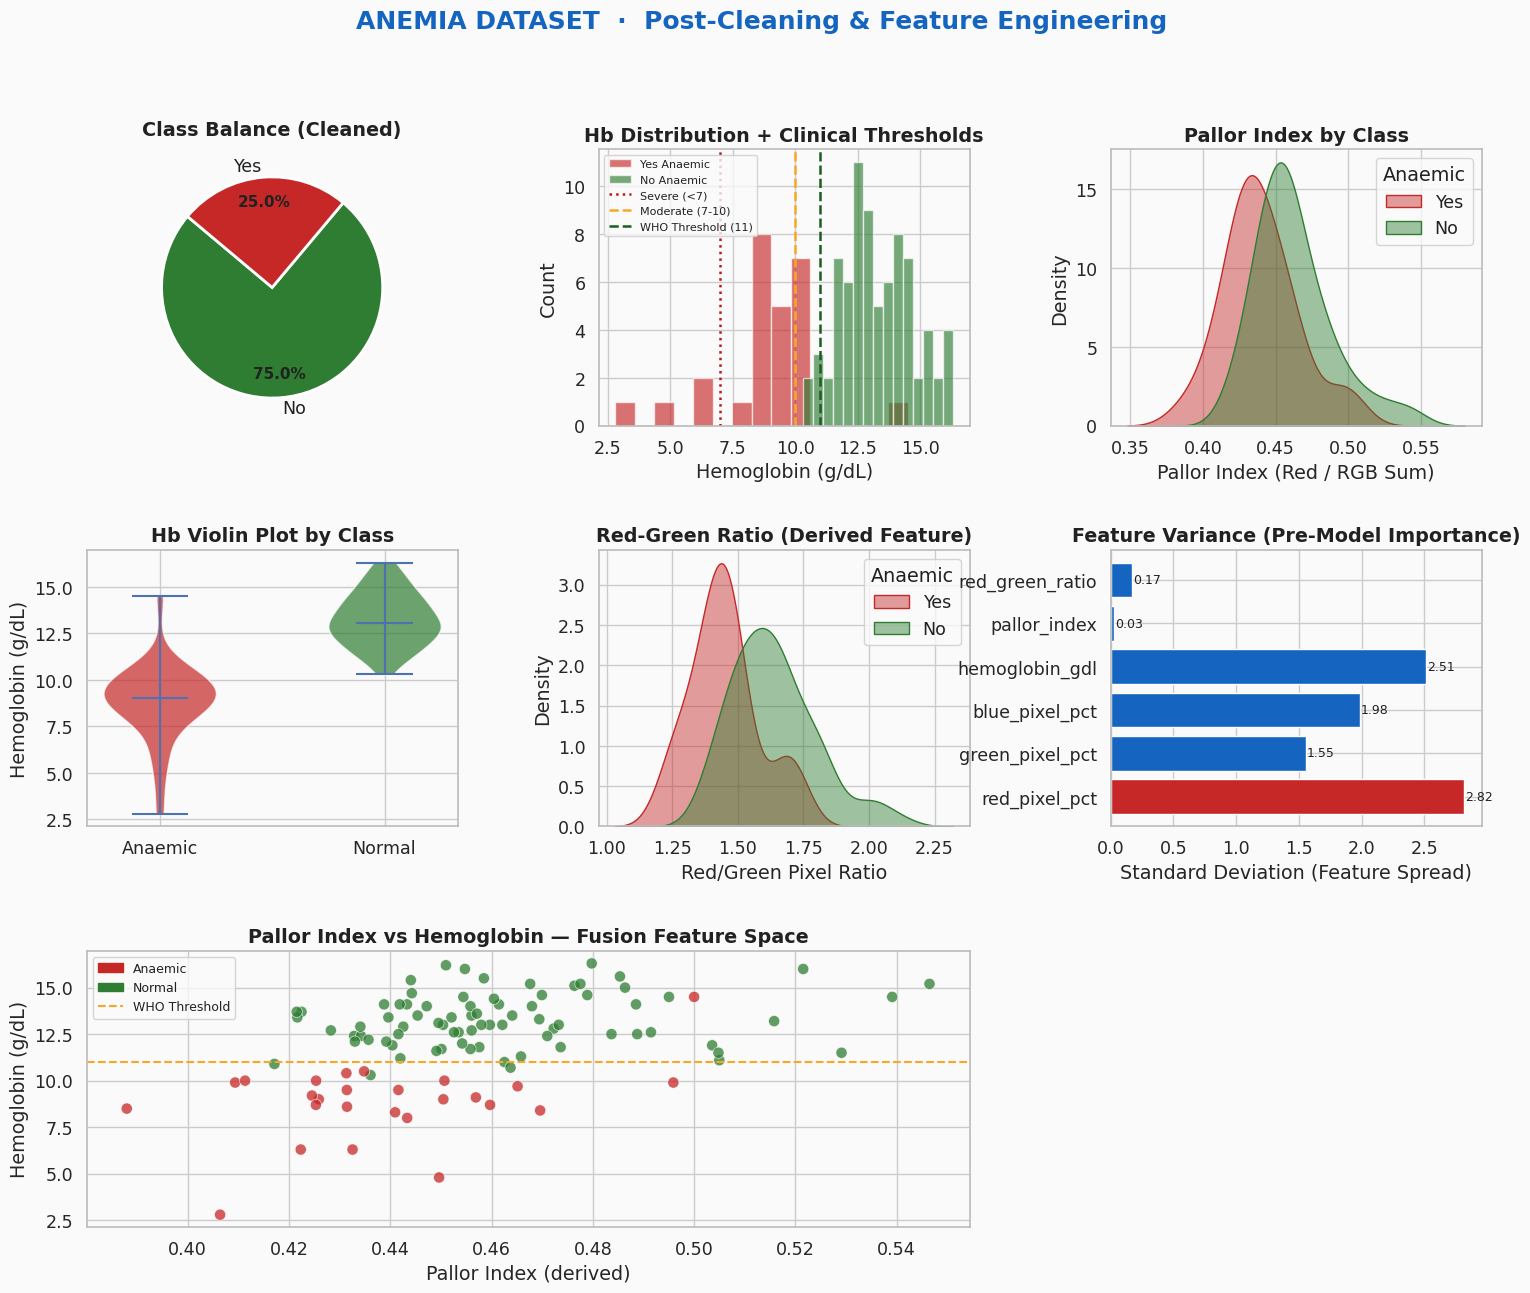

Saved: anemia_post_cleaning_features.png


In [8]:
# Post-Cleaning Visualisations

# Encode anaemic column for plotting
df['anaemic_encoded'] = df['anaemic'].map({'Yes': 1, 'No': 0})

fig2 = plt.figure(figsize=(18, 14))
fig2.patch.set_facecolor(PALETTE['bg'])
gs2  = gridspec.GridSpec(3, 3, figure=fig2, hspace=0.45, wspace=0.38)

fig2.suptitle(
    'ANEMIA DATASET  ·  Post-Cleaning & Feature Engineering',
    fontsize=18, fontweight='bold', color=PALETTE['secondary'], y=0.98
)

# 1: Class balance after cleaning
ax1 = fig2.add_subplot(gs2[0, 0])
clean_counts = df['anaemic'].value_counts()
wedges2, texts2, autotexts2 = ax1.pie(
    clean_counts, labels=clean_counts.index,
    autopct='%1.1f%%', colors=[PALETTE['positive'], PALETTE['primary']],
    startangle=140, pctdistance=0.78,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
for at in autotexts2:
    at.set_fontsize(11); at.set_fontweight('bold')
ax1.set_title('Class Balance (Cleaned)', fontweight='bold', pad=10)

# 2: Hb Distribution with clinical thresholds
ax2 = fig2.add_subplot(gs2[0, 1])
for label, clr in [('Yes', PALETTE['primary']), ('No', PALETTE['positive'])]:
    subset = df[df['anaemic'] == label]['hemoglobin_gdl']
    ax2.hist(subset, bins=15, alpha=0.65, color=clr, label=f'{label} Anaemic', edgecolor='white')
ax2.axvline(7.0,  color='#B71C1C', linestyle=':', linewidth=1.8, label='Severe (<7)')
ax2.axvline(10.0, color=PALETTE['accent'], linestyle='--', linewidth=1.8, label='Moderate (7-10)')
ax2.axvline(11.0, color='#1B5E20', linestyle='--', linewidth=1.8, label='WHO Threshold (11)')
ax2.set_xlabel('Hemoglobin (g/dL)'); ax2.set_ylabel('Count')
ax2.set_title('Hb Distribution + Clinical Thresholds', fontweight='bold')
ax2.legend(fontsize=8)

# 3: Pallor Index distribution
ax3 = fig2.add_subplot(gs2[0, 2])
for label, clr in [('Yes', PALETTE['primary']), ('No', PALETTE['positive'])]:
    subset = df[df['anaemic'] == label]['pallor_index']
    sns.kdeplot(subset, ax=ax3, color=clr, fill=True, alpha=0.45, label=label)
ax3.set_xlabel('Pallor Index (Red / RGB Sum)')
ax3.set_title('Pallor Index by Class', fontweight='bold')
ax3.legend(title='Anaemic')

# 4: Hb by class (violin plots)
ax4 = fig2.add_subplot(gs2[1, 0])
data_violin = [
    df[df['anaemic'] == 'Yes']['hemoglobin_gdl'].dropna(),
    df[df['anaemic'] == 'No']['hemoglobin_gdl'].dropna()
]
parts = ax4.violinplot(data_violin, positions=[1, 2], showmedians=True, showextrema=True)
for i, (pc, clr) in enumerate(zip(parts['bodies'], [PALETTE['primary'], PALETTE['positive']])):
    pc.set_facecolor(clr); pc.set_alpha(0.7)
ax4.set_xticks([1, 2]); ax4.set_xticklabels(['Anaemic', 'Normal'])
ax4.set_ylabel('Hemoglobin (g/dL)')
ax4.set_title('Hb Violin Plot by Class', fontweight='bold')

# 5: Red-Green ratio comparison
ax5 = fig2.add_subplot(gs2[1, 1])
for label, clr in [('Yes', PALETTE['primary']), ('No', PALETTE['positive'])]:
    subset = df[df['anaemic'] == label]['red_green_ratio']
    sns.kdeplot(subset, ax=ax5, color=clr, fill=True, alpha=0.45, label=label)
ax5.set_xlabel('Red/Green Pixel Ratio')
ax5.set_title('Red-Green Ratio (Derived Feature)', fontweight='bold')
ax5.legend(title='Anaemic')

# 6: Feature importance (variance-based proxy)
ax6 = fig2.add_subplot(gs2[1, 2])
feature_cols  = ['red_pixel_pct', 'green_pixel_pct', 'blue_pixel_pct',
                  'hemoglobin_gdl', 'pallor_index', 'red_green_ratio']
feature_vars  = df[feature_cols].std()
colors_feat   = [PALETTE['primary'] if v == feature_vars.max() else PALETTE['secondary']
                 for v in feature_vars]
bars = ax6.barh(feature_vars.index, feature_vars.values, color=colors_feat, edgecolor='white')
ax6.set_xlabel('Standard Deviation (Feature Spread)')
ax6.set_title('Feature Variance (Pre-Model Importance)', fontweight='bold')
for bar, val in zip(bars, feature_vars.values):
    ax6.text(val + 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=9)

# 7: Scatter matrix (key features)
ax7 = fig2.add_subplot(gs2[2, :2])
colors_sc2 = df['anaemic_encoded'].map({1: PALETTE['primary'], 0: PALETTE['positive']})
ax7.scatter(df['pallor_index'], df['hemoglobin_gdl'],
            c=colors_sc2, alpha=0.75, edgecolors='white', linewidth=0.5, s=65)
ax7.set_xlabel('Pallor Index (derived)'); ax7.set_ylabel('Hemoglobin (g/dL)')
ax7.axhline(11.0, color=PALETTE['accent'], linestyle='--', linewidth=1.5, label='WHO 11 g/dL')
ax7.set_title('Pallor Index vs Hemoglobin — Fusion Feature Space', fontweight='bold')
ax7.legend(handles=[
    Patch(color=PALETTE['primary'],  label='Anaemic'),
    Patch(color=PALETTE['positive'], label='Normal')
] + [plt.Line2D([0], [0], color=PALETTE['accent'], linestyle='--', label='WHO Threshold')],
    fontsize=9)

plt.savefig(OUTPUT_DIR + 'anemia_post_cleaning_features.png',
            dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print("Saved: anemia_post_cleaning_features.png")

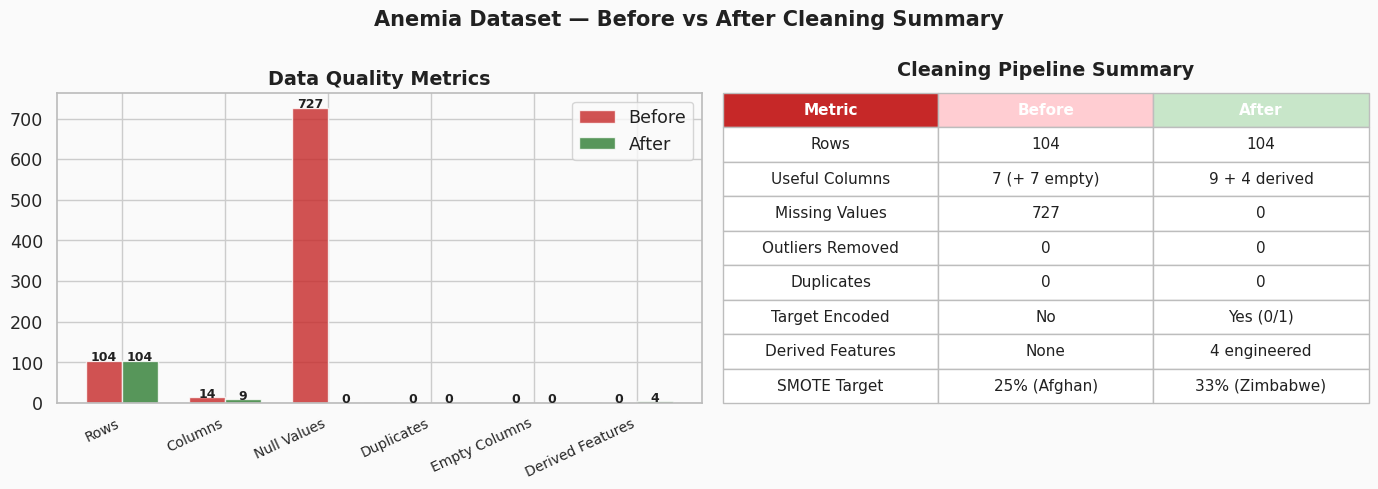

Saved: anemia_before_after_summary.png

Anemia EDA & Cleaning done


In [9]:
# BEFORE vs AFTER Comparison Summary
fig3, axes = plt.subplots(1, 2, figsize=(14, 5))
fig3.patch.set_facecolor(PALETTE['bg'])
fig3.suptitle('Anemia Dataset — Before vs After Cleaning Summary',
              fontsize=15, fontweight='bold', color=PALETTE['text'])

metrics_before = {
    'Rows':            len(df_raw),
    'Columns':         df_raw.shape[1],
    'Null Values':     df_raw.isnull().sum().sum(),
    'Duplicates':      df_raw.duplicated().sum(),
    'Empty Columns':   sum(1 for c in df_raw.columns if c.strip() == ''),
    'Derived Features': 0,
}
metrics_after = {
    'Rows':            len(df),
    'Columns':         df.shape[1],
    'Null Values':     df.isnull().sum().sum(),
    'Duplicates':      df.duplicated().sum(),
    'Empty Columns':   0,
    'Derived Features': 4,
}

x = np.arange(len(metrics_before))
w = 0.35
ax_l, ax_r = axes[0], axes[1]
bars_b = ax_l.bar(x - w/2, list(metrics_before.values()), w,
                   label='Before', color=PALETTE['primary'], alpha=0.8, edgecolor='white')
bars_a = ax_l.bar(x + w/2, list(metrics_after.values()),  w,
                   label='After',  color=PALETTE['positive'], alpha=0.8, edgecolor='white')
ax_l.set_xticks(x)
ax_l.set_xticklabels(list(metrics_before.keys()), rotation=25, ha='right', fontsize=10)
ax_l.set_title('Data Quality Metrics', fontweight='bold')
ax_l.legend()
for bar in bars_b:
    ax_l.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
              str(int(bar.get_height())), ha='center', fontsize=9, fontweight='bold')
for bar in bars_a:
    ax_l.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
              str(int(bar.get_height())), ha='center', fontsize=9, fontweight='bold')

# Text summary table
table_data = [
    ['Metric',             'Before',           'After'],
    ['Rows',               str(len(df_raw)),    str(len(df))],
    ['Useful Columns',     '7 (+ 7 empty)',     '9 + 4 derived'],
    ['Missing Values',     str(df_raw.isnull().sum().sum()), '0'],
    ['Outliers Removed',   '0',                 str(outlier_removed)],
    ['Duplicates',         str(dup_before),     '0'],
    ['Target Encoded',     'No',                'Yes (0/1)'],
    ['Derived Features',   'None',              '4 engineered'],
    ['SMOTE Target',       '25% (Afghan)',      '33% (Zimbabwe)'],
]
ax_r.axis('off')
tbl = ax_r.table(
    cellText=table_data[1:], colLabels=table_data[0],
    cellLoc='center', loc='center',
    colColours=[PALETTE['primary'], '#FFCDD2', '#C8E6C9'],
    bbox=[0.0, 0.0, 1.0, 1.0]
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
for key, cell in tbl.get_celld().items():
    cell.set_edgecolor('#BDBDBD')
    if key[0] == 0:
        cell.set_text_props(color='white', fontweight='bold')
ax_r.set_title('Cleaning Pipeline Summary', fontweight='bold', pad=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'anemia_before_after_summary.png',
            dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print("Saved: anemia_before_after_summary.png")
print("\nAnemia EDA & Cleaning done")

# Model Architecture:
    Branch A: CNN on RGB pixels - embedding
    Branch B: XGBoost on hemoglobin - probability
    Fusion:   Concatenate - Final anemia probability
    
Output: Probability of anemia for PPH risk fusion

In [10]:
# Anemia Prediction Model Training: CNN (Pixels) + XGBoost (Hb)

# Preparing data for modeling
X_pixels = df[['red_pixel_pct', 'green_pixel_pct', 'blue_pixel_pct', 
                'rgb_sum', 'red_green_ratio', 'pallor_index']].values
X_hb     = df[['hemoglobin_gdl']].values
y        = (df['anaemic'] == 'Yes').astype(int).values

X_train_pix, X_test_pix, X_train_hb, X_test_hb, y_train, y_test = train_test_split(
    X_pixels, X_hb, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(y_train)} | Test set: {len(y_test)}")
print(f"Train prevalence: {y_train.mean():.1%}")

# Branch A: Pixel CNN
print("\n[Branch A] Training CNN on pixel features")

if TF_AVAILABLE:
    # Normalize
    scaler_pix = StandardScaler()
    X_train_pix_norm = scaler_pix.fit_transform(X_train_pix)
    X_test_pix_norm  = scaler_pix.transform(X_test_pix)
    
    # CNN architecture
    inp_pix = Input(shape=(6,), name='pixel_input')
    x = Dense(128, activation='relu', name='pixel_dense_1')(inp_pix)
    x = BatchNormalization(name='pixel_bn_1')(x)
    x = Dropout(0.3, name='pixel_dropout_1')(x)
    x = Dense(64, activation='relu', name='pixel_dense_2')(x)
    x = BatchNormalization(name='pixel_bn_2')(x)
    x = Dropout(0.3, name='pixel_dropout_2')(x)
    pixel_embedding = Dense(32, activation='relu', name='pixel_embedding')(x)
    
    # Use only valid characters in model names (no spaces)
    cnn_model = Model(inputs=inp_pix, outputs=pixel_embedding, name='PixelCNN')
    print(cnn_model.summary())
    
    # Training CNN
    cnn_full = Model(inputs=inp_pix, outputs=Dense(1, activation='sigmoid', name='pixel_output')(pixel_embedding), name='PixelCNN_full')
    cnn_full.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    
    history_cnn = cnn_full.fit(
        X_train_pix_norm, y_train,
        epochs=100, batch_size=16, validation_split=0.2,
        callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
        verbose=0
    )
    
    # Get pixel embeddings
    pixel_train_emb = cnn_model.predict(X_train_pix_norm, verbose=0)
    pixel_test_emb  = cnn_model.predict(X_test_pix_norm, verbose=0)
    
    print(f"CNN trained | Final loss: {history_cnn.history['loss'][-1]:.4f}")
else:
    from sklearn.neural_network import MLPClassifier
    scaler_pix = StandardScaler()
    X_train_pix_norm = scaler_pix.fit_transform(X_train_pix)
    X_test_pix_norm  = scaler_pix.transform(X_test_pix)
    
    cnn_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42)
    cnn_model.fit(X_train_pix_norm, y_train)
    pixel_train_emb = cnn_model.predict_proba(X_train_pix_norm)
    pixel_test_emb  = cnn_model.predict_proba(X_test_pix_norm)
    print("MLP (fallback) trained on pixels")

# Branch B: XGBoost on Hemoglobin
print("\n[Branch B] Training XGBoost on hemoglobin")

# Hyperparameter grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb_base = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_base, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search.fit(X_train_hb, y_train)

xgb_model = grid_search.best_estimator_
print(f" XGBoost trained | Best params: {grid_search.best_params_}")
print(f"  Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Get Hb probabilities
hb_train_prob = xgb_model.predict_proba(X_train_hb)[:, 1:2]
hb_test_prob  = xgb_model.predict_proba(X_test_hb)[:, 1:2]

# Fusion: Combine embeddings
print("\n[Fusion] Combining pixel embedding + Hb probability")

X_train_fused = np.concatenate([pixel_train_emb, hb_train_prob], axis=1)
X_test_fused  = np.concatenate([pixel_test_emb, hb_test_prob], axis=1)

print(f"  Fusion vector shape: {X_train_fused.shape}")

# Final meta-classifier
fusion_clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
fusion_clf.fit(X_train_fused, y_train)

# Predictions
y_pred = fusion_clf.predict(X_test_fused)
y_prob = fusion_clf.predict_proba(X_test_fused)[:, 1]

# EVALUATION

f1  = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\nTest Set Performance:")
print(f"  F1 Score : {f1:.4f}")
print(f"  ROC-AUC  : {auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anaemic']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

fig_eval = plt.figure(figsize=(14, 5))
fig_eval.patch.set_facecolor(PALETTE['bg'])

ax1 = fig_eval.add_subplot(1, 2, 1)
ax1.plot(fpr, tpr, color=PALETTE['primary'], linewidth=2, label=f'ROC (AUC={auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
ax1.set_xlabel('False Positive Rate'); ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve — Anemia Prediction', fontweight='bold')
ax1.legend(); ax1.grid(alpha=0.3)

ax2 = fig_eval.add_subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax2,
            xticklabels=['Normal', 'Anaemic'], yticklabels=['Normal', 'Anaemic'])
ax2.set_xlabel('Predicted'); ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'anemia_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n Saved: anemia_model_evaluation.png")


Train set: 83 | Test set: 21
Train prevalence: 25.3%

[Branch A] Training CNN on pixel features


Model: "PixelCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pixel_input (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_dense_1 (Dense)           │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_bn_1 (BatchNormalization) │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_dropout_1 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_dense_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_bn_2 (BatchNormalization) │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_dropout_2 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_embedding (Dense)         │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,000 (46.88 KB)

 Trainable params: 11,616 (45.38 KB)

 Non-trainable params: 384 (1.50 KB)

None
CNN trained | Final loss: 0.4151

[Branch B] Training XGBoost on hemoglobin
 XGBoost trained | Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  Best CV ROC-AUC: 0.9635

[Fusion] Combining pixel embedding + Hb probability
  Fusion vector shape: (83, 33)

Test Set Performance:
  F1 Score : 1.0000
  ROC-AUC  : 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        16
     Anaemic       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21


Confusion Matrix:
[[16  0]
 [ 0  5]]

 Saved: anemia_model_evaluation.png
